In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import argparse
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import Deconvolution
from captum.attr import Saliency
from captum.attr import GuidedBackprop
from captum.attr import GuidedGradCam
from captum.attr import InputXGradient
from captum.attr import DeepLift
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import Occlusion
from captum.attr import visualization as viz

from captum.attr import GradientShap

In [2]:
# Load the model(resnet 18) & dataset
model=models.resnet18(pretrained=True)
model=model.eval()

In [3]:
# Load labels
labels_path = '../.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [4]:
# Image Load & Preprocessing
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('pome.jpg').convert('RGB')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [5]:
# Predict the class of the input image
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
score=prediction_score.squeeze().item()
print('Predicted:', predicted_label, '%4.2f'%(score*100),'%', '(',score,')')

Predicted: Pomeranian 94.09 % ( 0.940920889377594 )


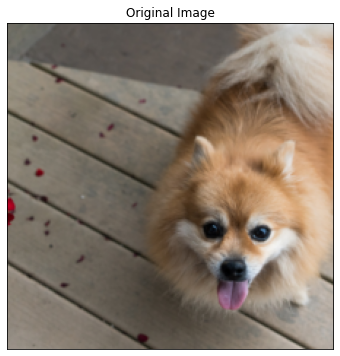

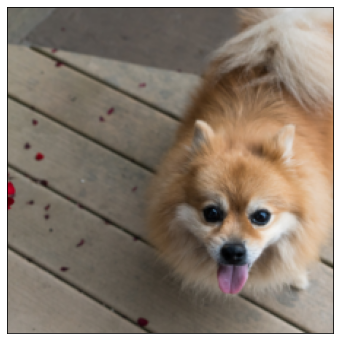

In [22]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#6666ff'),
                                                  (0.25, '#33ff00'),
                                                  (1.0, '#ff0000')], N=256)

_=viz.visualize_image_attr(None,np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),method="original_image", 
  title="Original Image")
# 논문용 이미지
_=viz.visualize_image_attr(None,np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                           method="original_image")

/home/shcho/anaconda3/envs/jsyoo/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/shcho/anaconda3/envs/jsyoo/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


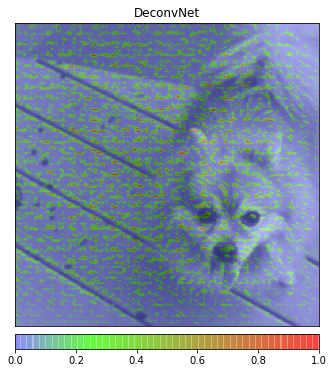

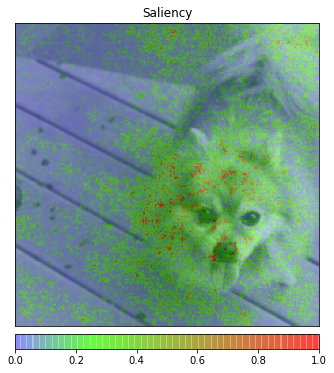

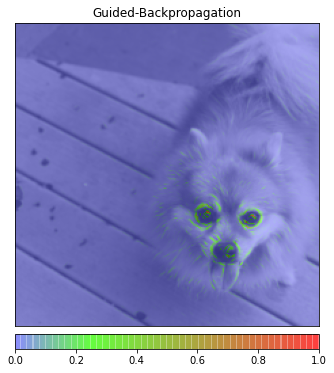

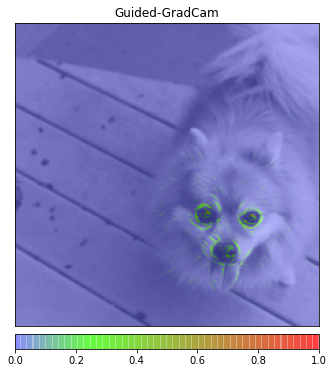

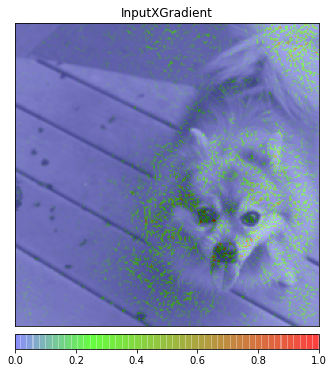

In [7]:
methods=[Deconvolution, Saliency, GuidedBackprop, GuidedGradCam,
        InputXGradient, DeepLift, IntegratedGradients]

# DeconvNet
deconv=Deconvolution(model)
deconv_attributions=deconv.attribute(input, target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(deconv_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      title="DeconvNet")
# Saliency
saliency=Saliency(model)
saliency_attributions=saliency.attribute(input,target=pred_label_idx,abs=True)
_ = viz.visualize_image_attr(np.transpose(saliency_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Saliency")
# Guided-Backpropagation
gbp=GuidedBackprop(model)
gbp_attributions=gbp.attribute(input,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(gbp_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Guided-Backpropagation")
# Guided-GradCam
ggc=GuidedGradCam(model,model.layer4)
ggc_attributions=ggc.attribute(input,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(ggc_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign="positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Guided-GradCam")
# InputXGradient
ixg=InputXGradient(model)
ixg_attributions=ixg.attribute(input,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(ixg_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign="positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="InputXGradient")


In [8]:
"""
# DeepLIFT
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=pred_label_idx,
                                              **kwargs
                                             )
    
    return tensor_attributions
dl=DeepLift(model)
dl_attributions=dl.attribute(input,baselines=0,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(dl_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                            method= "heat_map",
                            sign= "all",
                            cmap=default_cmap,
                            show_colorbar=True,
                            title="DeepLIFT")
"""

'\n# DeepLIFT\ndef attribute_image_features(algorithm, input, **kwargs):\n    model.zero_grad()\n    tensor_attributions = algorithm.attribute(input,\n                                              target=pred_label_idx,\n                                              **kwargs\n                                             )\n    \n    return tensor_attributions\ndl=DeepLift(model)\ndl_attributions=dl.attribute(input,baselines=0,target=pred_label_idx)\n_ = viz.visualize_image_attr(np.transpose(dl_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),\n                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),\n                            method= "heat_map",\n                            sign= "all",\n                            cmap=default_cmap,\n                            show_colorbar=True,\n                            title="DeepLIFT")\n'

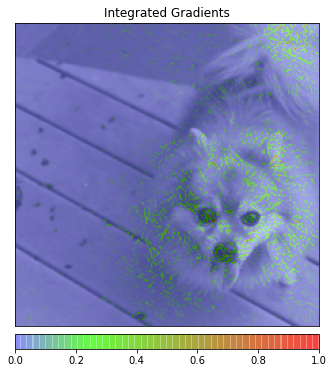

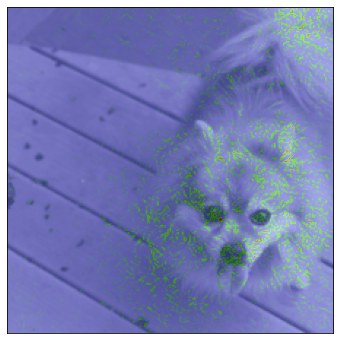

In [20]:
# IntergratedGradients
ig=IntegratedGradients(model)
ig_attributions=ig.attribute(input,target=pred_label_idx,n_steps=200)
_ = viz.visualize_image_attr(np.transpose(ig_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1,
                            title="Integrated Gradients")
# 논문용 이미지
_ = viz.visualize_image_attr(np.transpose(ig_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             sign='positive',
                             outlier_perc=1)

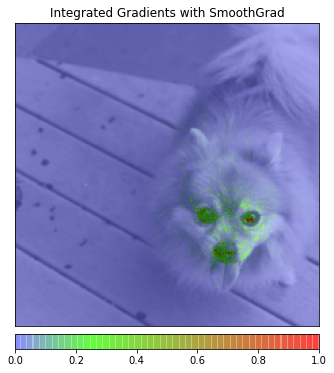

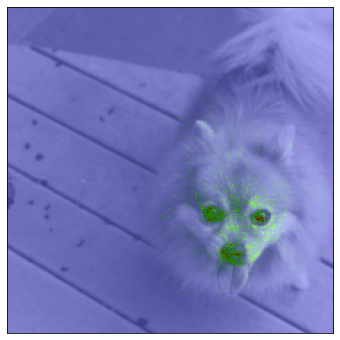

In [21]:
# IntegratedGradients with SmoothGrad
ignt=IntegratedGradients(model)
nt=NoiseTunnel(ignt)
ignt_attributions=nt.attribute(input, target=pred_label_idx, nt_type='smoothgrad_sq', n_samples=10)
_ = viz.visualize_image_attr(np.transpose(ignt_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                        sign='positive',
                            title="Integrated Gradients with SmoothGrad")
# 논문용 이미지
_ = viz.visualize_image_attr(np.transpose(ignt_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             sign='positive')

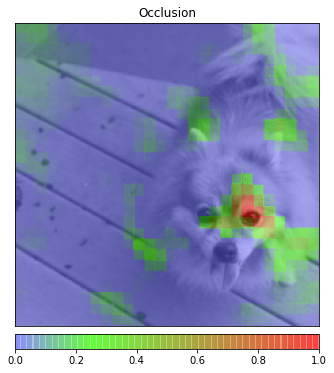

In [11]:
# Occlusion-based attribution
oc=Occlusion(model)
oc_attributions=oc.attribute(input,strides=(3,8,8),
                            target=pred_label_idx,
                            sliding_window_shapes=(3,15,15),
                            baselines=0)
# (1,2,0)을 안넣으면 이미지가 좌로 90도 돌아가서 출력됨
_=viz.visualize_image_attr(np.transpose(oc_attributions.squeeze().cpu().detach().numpy(),(1,2,0)),
                           np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),
                            method='blended_heat_map',
                            cmap=default_cmap,
                            show_colorbar=True,
                            sign='positive',
                            outlier_perc=2,
                            title="Occlusion")

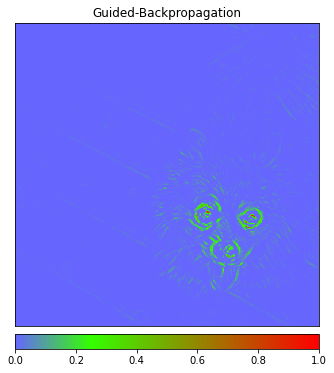

In [12]:
_ = viz.visualize_image_attr(np.transpose(gbp_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Guided-Backpropagation")

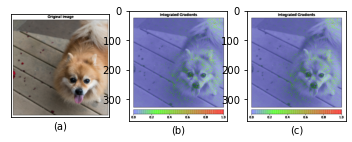

In [19]:
import matplotlib.pyplot as plt
import cv2
og=cv2.imread('og.png')
ig=cv2.imread('ig.png')
ignt=cv2.imread('ig.png')

fig=plt.figure()

ax1=fig.add_subplot(1,3,1)
ax1.imshow(cv2.cvtColor(og,cv2.COLOR_BGR2RGB))
ax1.set_xlabel('(a)')
ax1.set_xticks([]), ax1.set_yticks([])

ax2=fig.add_subplot(1,3,2)
ax2.imshow(cv2.cvtColor(ig,cv2.COLOR_BGR2RGB))
ax2.set_xlabel('(b)')
ax2.set_xticks([]), ax1.set_yticks([])

ax3=fig.add_subplot(1,3,3)
ax3.imshow(cv2.cvtColor(ignt,cv2.COLOR_BGR2RGB))
ax3.set_xlabel('(c)')
ax3.set_xticks([]), ax1.set_yticks([])

plt.show()